# SHAP explain 12 features: for LG2

LG2: trained on imbalanced ClinVar with 12 features

In [3]:
import gzip
import pandas as pd
import numpy as np
from joblib import dump, load

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

## preprocessing

In [4]:
df = pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)
df

Columns (32,49,50,51,54,56,58,92) have mixed types. Specify dtype option on import or set low_memory=False.


,CLNSIG,CADD,AF_ESP,AF_EXAC,AF_TGP,Frq,GNOMADAF,GNOMADAF_popmax,Hom,ORIGIN,...,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,SpliceAI_pred_DS_AG,SpliceAI_pred_DS_AL,SpliceAI_pred_DS_DG,SpliceAI_pred_DS_DL,SpliceAI_pred_SYMBOL,genomic_superdups_frac_match
0,Uncertain_significance,26.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-30.0,11.0,10.0,-30.0,0.01,0.00,0.09,0.00,SAMD11,NaN
1,Likely_benign,13.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,7.0,-34.0,6.0,42.0,0.00,0.02,0.03,0.00,SAMD11,NaN
2,Likely_benign,31.000,NaN,NaN,NaN,0.00056,0.000414,0.000195,NaN,1.0,...,41.0,-47.0,-7.0,44.0,0.00,0.01,0.06,0.00,SAMD11,NaN
3,Uncertain_significance,28.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,10.0,-47.0,34.0,-14.0,0.00,0.00,0.03,0.02,SAMD11,NaN
4,Likely_benign,11.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-35.0,-50.0,12.0,24.0,0.00,0.00,0.01,0.00,SAMD11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468907,Benign,7.587,NaN,NaN,NaN,0.00070,NaN,NaN,5.0,1.0,...,25.0,35.0,0.0,16.0,0.00,0.00,0.00,0.00,USP9Y,NaN
1468908,Uncertain_significance,23.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468909,Benign,11.200,0.00614,0.00589,0.00243,0.00671,NaN,NaN,48.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468910,Uncertain_significance,21.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
""" 1. choose featuresV1"""

featureV1 = ['CLNSIG','CADD', 'AF_TGP', 'Frq', 'IMPACT','GNOMADAF_popmax', 'Hom', 'ORIGIN',
       'SPIDEX', 'SWEGENAF', 'Consequence', 'BIOTYPE', 'SIFT',
       'PolyPhen', 'MES-SWA_acceptor_alt', 'MES-SWA_acceptor_diff',
       'MES-SWA_donor_alt', 'MES-SWA_donor_diff', 'MaxEntScan_alt',
       'MaxEntScan_diff', 'GERP++_RS', 'REVEL_score',
       'phastCons100way_vertebrate', 'phyloP100way_vertebrate', 'LoFtool',
       'pLI_gene_value', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL']         # keep CLNSIG,

df_1 = df[featureV1]



""" 2. only remove missing target """
# for some features with fewer missing
# drop_nan_features = ['CLNSIG','CADD','Consequence','IMPACT','BIOTYPE','MES-SWA_acceptor_alt','MES-SWA_acceptor_diff',
# 'MES-SWA_donor_alt','MES-SWA_donor_diff','pLI_gene_value']

drop_nan_features = ['CLNSIG']
df_1 = df_1.dropna(subset=drop_nan_features)

In [6]:
""" 3. deal with target feature """
# """  CLNSIG: tansfer to 4 classes__ benign,pathogenic,uncertain,others
# NOTE:
# (only count name before |)   explanation-- https://www.ncbi.nlm.nih.gov/clinvar/docs/clinsig/#clinsig_scv

# 1. pathogenic: Pathogenic, Pathogenic/Likely_pathogenic, Likely_pathogenic
# 2. benign: Likely_benign, Benign, Benign/Likely_benign
# 3. uncertain: Uncertain_significance, 
# 4. others: Uncertain_risk_allele, risk_factor, protective, other, not_provided, Likely_risk_allele, drug_response, Conflicting_interpretations_of_pathogenicity, confers_sensitivity, associatio, Affects

df_1 = df_1.copy()
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_significance|_risk_factor', 'Uncertain_significance|_other', 'Uncertain_significance|_drug_response','Uncertain_significance|_association','Uncertain_significance|_Affects','Uncertain_significance'], 'uncertain')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Pathogenic|_risk_factor','Pathogenic|_protective','Pathogenic|_other','Pathogenic|_drug_response|_other','Pathogenic|_drug_response','Pathogenic|_confers_sensitivity','Pathogenic|_association','Pathogenic|_Affects','Pathogenic/Likely_risk_allele','Pathogenic/Likely_pathogenic|_risk_factor','Pathogenic/Likely_pathogenic|_other','Pathogenic/Likely_pathogenic|_drug_response','Pathogenic/Likely_pathogenic','Pathogenic','Likely_pathogenic|_risk_factor','Likely_pathogenic|_other','Likely_pathogenic|_drug_response','Likely_pathogenic|_association','Likely_pathogenic|_Affects','Likely_pathogenic,_low_penetrance','Likely_pathogenic'], 'pathogenic')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Likely_benign|_risk_factor','Likely_benign|_other','Likely_benign|_drug_response|_other','Likely_benign','Benign|_risk_factor','Benign|_protective','Benign|_other','Benign|_drug_response','Benign|_confers_sensitivity','Benign|_association|_confers_sensitivity','Benign|_association','Benign/Likely_benign|_risk_factor','Benign/Likely_benign|_other|_risk_factor','Benign/Likely_benign|_other','Benign/Likely_benign|_drug_response|_other','Benign/Likely_benign|_drug_response','Benign/Likely_benign|_association','Benign/Likely_benign','Benign'], 'benign')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_risk_allele|_risk_factor','Uncertain_risk_allele','risk_factor','protective','protective|_risk_factor','other', 'not_provided','Likely_risk_allele','drug_response|_risk_factor','drug_response|_other','drug_response','Conflicting_interpretations_of_pathogenicity|_risk_factor','Conflicting_interpretations_of_pathogenicity|_protective','Conflicting_interpretations_of_pathogenicity|_other|_risk_factor','Conflicting_interpretations_of_pathogenicity|_other','Conflicting_interpretations_of_pathogenicity|_drug_response|_other','Conflicting_interpretations_of_pathogenicity|_drug_response','Conflicting_interpretations_of_pathogenicity|_association|_risk_factor','Conflicting_interpretations_of_pathogenicity|_association','Conflicting_interpretations_of_pathogenicity','confers_sensitivity','association|_risk_factor','association_not_found','association','Affects|_risk_factor','Affects|_association','Affects'], 'others')

# only keep benign & pathogenic
df_1 = df_1.loc[df_1['CLNSIG'].isin(['benign','pathogenic'])]

# label encoder
map_clnsig={'pathogenic':1,'benign':0}
df_1['CLNSIG']=df_1['CLNSIG'].map(lambda s: map_clnsig.get(s) if s in map_clnsig else s)
# df_1["CLNSIG"].unique()

In [7]:
"""4.2  keep imbalance classes """

# split
from sklearn.model_selection import train_test_split

X, y = df_1.iloc[:, 1:], df_1.iloc[:, 0]
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                    test_size=0.3,
                    random_state=42,
                    stratify=y)

#  predict by model
C = 10

In [1]:
## load LG2 and preprocessor2:

lr = load('/Users/nancy/Desktop/RS_projects/result/03_ML/01_train_model/02_featureV2/02_12feats_clinvar_LG.joblib')
preprocessor = load ('/Users/nancy/Desktop/RS_projects/result/03_ML/01_train_model/02_featureV2/02_12feats_clinvar_preprocessor.joblib')

NameError: name 'load' is not defined

In [9]:
## preprocessing X_test

X_train_proce = preprocessor.transform(X_train)
X_test_proce = preprocessor.transform(X_test)

In [10]:
cols = ['CADD',
 'Frq',
 'GNOMADAF_popmax',
 'pLI_gene_value',
 'SpliceAI_pred_DS_AL',
 'SpliceAI_pred_DS_DG',
 'SpliceAI_pred_DS_DL',
 'miss_REVEL_score',
 'miss_SpliceAI_pred_DS_AG',
 'miss_PolyPhen',
 'REVEL_score',
 'SpliceAI_pred_DS_AG',
 'Consequence',
 'PolyPhen',
 'BIOTYPE_0',
 'BIOTYPE_1',
 'BIOTYPE_2',
 'BIOTYPE_3',
 'BIOTYPE_4']    # 19, copy from 014_retrain_12featuresV2--2.ipynb

# shap: for explain features and models

maybe use it after feature selection, it can be used to interpret our model

https://github.com/slundberg/shap ;

For  linear  models,  if  we  assume  input  feature  independence  (Equation  11),  SHAP  values  can  be 
approximated  directly from the  model’s  weight  coefﬁcients.

SHAP values is given to represent the feature

In [11]:
import shap

## Explain the linear model
explainer = shap.LinearExplainer(lr, X_train_proce, feature_dependence="independent")
shap_values = explainer.shap_values(X_test_proce)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [12]:
shap_values.shape

(237256, 19)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


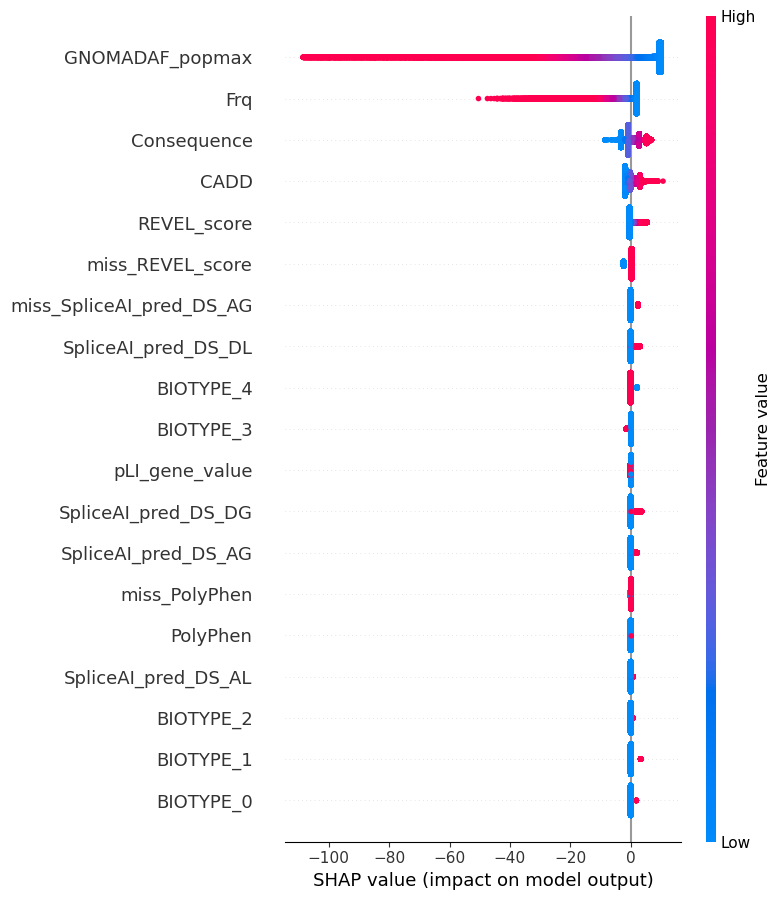

In [18]:
## Summarize the effect of all the features
shap.summary_plot(shap_values, X_test_proce, feature_names=cols)

## The plot shows the most important features for predicting the class. It also shows the direction of how it’s going to drive the prediction.

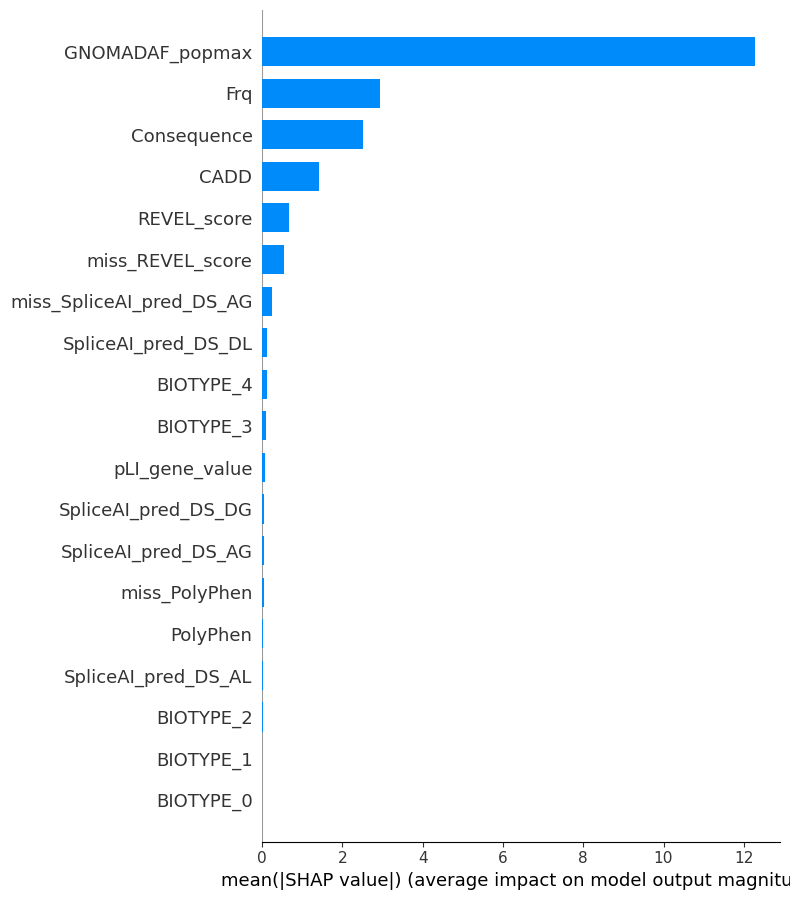

In [14]:
## Global feature importance using SHAP

shap.summary_plot(shap_values, X_test_proce, feature_names=cols,plot_type="bar")

In [15]:
values = np.abs(shap_values).mean(0)  # mean of shapely values in each column
shap_value_features = pd.DataFrame(data=values, index=cols, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

shap_value_features
# len(shap_value_features)

,SHAP
GNOMADAF_popmax,12.287651
Frq,2.926921
Consequence,2.504512
CADD,1.411764
REVEL_score,0.660572
miss_REVEL_score,0.540598
miss_SpliceAI_pred_DS_AG,0.233512
SpliceAI_pred_DS_DL,0.126840
BIOTYPE_4,0.112611
BIOTYPE_3,0.092864
